In [4]:
pip install pandas networkx[default] -U matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.2 MB 6.4 MB/s 
     |████████████████████████████████| 9.4 MB 75.9 MB/s 
     |████████████████████████████████| 965 kB 56.3 MB/s 
     |████████████████████████████████| 295 kB 62.6 MB/s 
     |████████████████████████████████| 33.8 MB 1.2 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
# Load data

url = "https://media.githubusercontent.com/media/adeindriawan/nft-fraud-detection/master/transfers.csv"
df = pd.read_csv(url)
df['label'] = 'nonfraud'
print(df)

                                     event_id  \
0        cd816651-56b2-4ed9-887c-c83de732428d   
1        82cc5228-eb80-4e0d-9f6f-e644dec3ab06   
2        6e1f9cc4-d1df-4a6b-972d-a20765beb326   
3        43dc27a7-a72d-4894-809c-e868de05f7ee   
4        47b7839b-9b87-442d-b2c1-9ebedcad8e06   
...                                       ...   
4514724  d45af108-4869-44bb-833d-2539faba0f1b   
4514725  73c81c59-c17a-4154-8bbc-5d72a27ee905   
4514726  27f9c904-06cf-4807-9011-d5ecae274249   
4514727  89718578-d85b-493b-ab2f-8bd49187109c   
4514728  a8f8314a-36c5-4999-88e6-86dc4b3e347a   

                                          transaction_hash  block_number  \
0        0x0c73daad5e6946e6b2f1374846d6ba3025d6e6a2569f...      12936373   
1        0x0c73daad5e6946e6b2f1374846d6ba3025d6e6a2569f...      12936373   
2        0x0c73daad5e6946e6b2f1374846d6ba3025d6e6a2569f...      12936373   
3        0x0c73daad5e6946e6b2f1374846d6ba3025d6e6a2569f...      12936373   
4        0x0c73daad5e6946e6b2f1

In [4]:
threshold = 5
multiple_trx = df[['nft_address', 'token_id']].groupby(['nft_address', 'token_id']).size().loc[lambda x: x > threshold].reset_index(name='freq').sort_values(by=['freq'], ascending=False)
print(multiple_trx)

                                      nft_address  \
15587  0xACd3CF818EFe8ddce84C585ddCB147c4C844D3b3   
22702  0xb7F7F6C52F2e2fdb1963Eab30438024864c313F6   
7709   0x60F80121C31A0d46B5279700f9DF786054aa5eE5   
22623  0xb7F7F6C52F2e2fdb1963Eab30438024864c313F6   
22768  0xb7F7F6C52F2e2fdb1963Eab30438024864c313F6   
...                                           ...   
10210  0x629A673A8242c2AC4B7B8C5D8735fbeac21A6205   
16993  0xBC4CA0EdA7647A8aB7C2061c2E118A18a936f13D   
16994  0xBC4CA0EdA7647A8aB7C2061c2E118A18a936f13D   
10209  0x629A673A8242c2AC4B7B8C5D8735fbeac21A6205   
16584  0xBC4CA0EdA7647A8aB7C2061c2E118A18a936f13D   

                                                token_id  freq  
15587                                                  0   272  
22702                                                639    72  
7709                                             1208910    72  
22623                                               3920    67  
22768                                 

In [14]:
from networkx import simple_cycles
# from IPython.display import Javascript  # Restrict height of output cell.
# display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

for i, v in enumerate(multiple_trx.iterrows()):
  filter1 = df['nft_address'] == v[1]['nft_address']
  filter2 = df['token_id'] == v[1]['token_id']
  f_m_t = df[filter1 & filter2]
  f_m_t_sorted = f_m_t.sort_values(by=['timestamp'], ascending=True)
  
  G = nx.DiGraph()
  unique_addresses = pd.concat([f_m_t_sorted['from_address'], f_m_t_sorted['to_address']]).unique()
  account_nodes = [tuple((x, {"entity": "Account", "address": x})) for x in unique_addresses]
  G.add_nodes_from(account_nodes)
  for index, item in f_m_t.iterrows():
    G.add_edge(item['from_address'], item['to_address'], rel='TRANSFERED_TO')

  loops = list(simple_cycles(G))
  for k,l in enumerate(loops):
    if len(l) > 1:
      first_node = l[0]
      second_node = l[1]

      last_node = l[-1:][0]
      n1_1st_trx = f_m_t_sorted['from_address'] == first_node
      n2_1st_trx = f_m_t_sorted['to_address'] == second_node

      ts_1st_trx = f_m_t_sorted[n1_1st_trx & n2_1st_trx]

      n1_last_trx = f_m_t_sorted['from_address'] == last_node
      n2_last_trx = f_m_t_sorted['to_address'] ==  first_node

      ts_last_trx = f_m_t_sorted[n1_last_trx & n2_last_trx]
      trx_time_diff = abs(ts_last_trx['timestamp'].max() - ts_1st_trx['timestamp'].min())
      if trx_time_diff < 43200:
        df.loc[filter1 & filter2, 'label'] = 'fraud'
        break
    else:
      print(l)

  print(i)



Streaming output truncated to the last 5000 lines.
21587
21588
21589
21590
21591
21592
21593
21594
21595
21596
21597
21598
21599
21600
21601
21602
21603
21604
21605
21606
21607
21608
21609
21610
21611
21612
21613
21614
['0xE690403C8517B9d4f0E3FAbD5f427cB22dBa1E62']
21615
21616
21617
21618
21619
21620
21621
21622
21623
21624
21625
21626
21627
21628
21629
21630
21631
21632
21633
21634
21635
21636
21637
21638
21639
21640
21641
21642
21643
21644
21645
21646
21647
21648
21649
21650
21651
21652
21653
21654
21655
21656
21657
21658
21659
21660
21661
21662
21663
21664
21665
21666
21667
21668
21669
21670
21671
21672
21673
21674
21675
21676
21677
21678
21679
21680
21681
21682
21683
21684
21685
21686
21687
21688
21689
21690
21691
21692
21693
21694
21695
21696
21697
21698
21699
21700
21701
21702
21703
21704
21705
21706
21707
21708
21709
21710
21711
21712
21713
21714
21715
21716
21717
21718
21719
21720
21721
21722
21723
21724
21725
21726
21727
21728
21729
21730
21731
21732
21733
21734
21735
21736
21

In [1]:
fraud_label_filter = df['label'] == 'fraud'
df[fraud_label_filter]

NameError: ignored

In [ ]:
df.to_csv('transfers_with_label.csv')

CONTOH DATA LABELING

In [2]:
url = "0x053afa4D216F20DD0c15631Fb1Fb26a02B152c09_1.csv"
df = pd.read_csv(url)
df['label'] = 'nonfraud'
print(df)

                                event_id  \
0   1ec14616-f732-4a10-9053-9dd7009cf071   
1   b9369d85-ad9b-4328-9aaa-c41afdc3394e   
2   b235da12-fc5f-4250-91af-311892b63821   
3   21b93550-0922-447b-8d82-ff8e3d124bda   
4   142b1435-526a-4cb0-b328-548199df8da5   
5   9e8792ae-a581-4099-a513-4dd080d21c4b   
6   59b7c882-ddb0-42f2-a81e-1235e253cb88   
7   b43f2046-6dfa-41d2-ac94-5f3ca958af8c   
8   72cc5ee5-7ef2-4581-b24f-832d5ae7e671   
9   08f99d63-522d-4593-9760-318e42f583dc   
10  d6341027-c026-456f-a9f6-93d4eb867e4b   
11  1a251f6d-85d6-4833-830c-c16ab1f929bd   
12  595d94c7-1a00-487a-acd2-378fc827b2e4   
13  bb3d6461-c078-461b-9108-fbb787483a30   
14  c3270793-eb91-4260-b9c0-ab37d005ed6e   
15  c36dc2f7-eca7-4476-bb25-987aeb0e4273   
16  911f528f-9320-413c-a2aa-73e7371b1b25   
17  531db15b-2229-46f4-b1bd-a1d921ba6c83   
18  b6c6a0cd-a095-4491-8e4b-08c1e61d3b66   
19  7eb5030b-ae71-4d7f-9f03-a2b5d4daa7c2   
20  b5a8a3da-e35b-4117-bd4f-d3ac0716e82d   
21  063a27e4-2ca5-4d05-b3d5-2737

In [3]:
f1 = df['nft_address'] == '0x053afa4D216F20DD0c15631Fb1Fb26a02B152c09'
f2 = df['token_id'] == '1'

df.loc[f1 & f2, 'label'] = 'fraud'
df[f1 & f2]

,event_id,nft_address,token_id,from_address,to_address,transaction_value,timestamp,label


In [4]:
ex = '0x053afa4D216F20DD0c15631Fb1Fb26a02B152c09_1.csv'
ex_df = pd.read_csv(ex)
ex_df_sorted = ex_df.sort_values(by=['timestamp'], ascending=True)
print(len(ex_df_sorted))

45


In [5]:
G = nx.DiGraph()

In [12]:
unique_addresses = pd.concat([ex_df_sorted['from_address'], ex_df_sorted['to_address']]).unique()
account_nodes = [tuple((x, {"entity": "Account", "address": x})) for x in unique_addresses]
G.add_nodes_from(account_nodes)
print(len(unique_addresses))
print(account_nodes)

10
[('0x5b411285bDE8a6E0237B465B5Cb6577040885c98', {'entity': 'Account', 'address': '0x5b411285bDE8a6E0237B465B5Cb6577040885c98'}), ('0xA731178E11A70d65BDEeD6f6575cD2ccfD9C265A', {'entity': 'Account', 'address': '0xA731178E11A70d65BDEeD6f6575cD2ccfD9C265A'}), ('0x99988890F2DE1d59e1EB76d2f34CDE371044b8C8', {'entity': 'Account', 'address': '0x99988890F2DE1d59e1EB76d2f34CDE371044b8C8'}), ('0x281e8D319088a7BCf99C3F98E6C145e9Be62cF66', {'entity': 'Account', 'address': '0x281e8D319088a7BCf99C3F98E6C145e9Be62cF66'}), ('0xe2ca7390e76c5A992749bB622087310d2e63ca29', {'entity': 'Account', 'address': '0xe2ca7390e76c5A992749bB622087310d2e63ca29'}), ('0xF962f8D31b4f5e9794C76658b8E09aE08B4F0506', {'entity': 'Account', 'address': '0xF962f8D31b4f5e9794C76658b8E09aE08B4F0506'}), ('0xea5ABc1a1689984EbFDC41130886BdAEB5c24078', {'entity': 'Account', 'address': '0xea5ABc1a1689984EbFDC41130886BdAEB5c24078'}), ('0x9428E55418755b2F902D3B1f898A871AB5634182', {'entity': 'Account', 'address': '0x9428E55418755b2F9

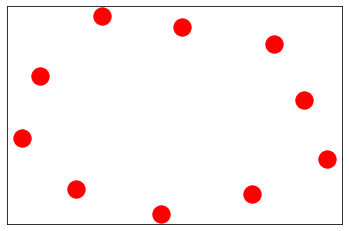

In [7]:
node_pos=nx.spring_layout(G) #Any layout will work here, including nx.spring_layout(G)
nx.draw_networkx_nodes(G,pos=node_pos, node_color='r')#draw nodes
plt.show() 

In [8]:
for index, item in ex_df_sorted.iterrows():
  G.add_edge(item['from_address'], item['to_address'], rel='TRANSFERED_TO')

/usr/local/lib/python3.8/dist-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


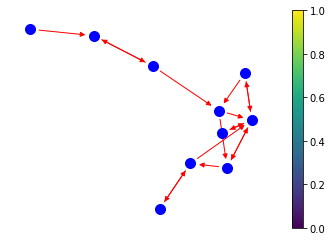

In [9]:
nodes = G.nodes()

pos = nx.spring_layout(G)
ec = nx.draw_networkx_edges(G, pos, edge_color='r')
nc = nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color='b', 
                            node_size=100, cmap=plt.cm.jet)

plt.colorbar(nc)
plt.axis('off')
plt.show()

In [22]:
from networkx import degree_centrality

dc = degree_centrality(G)
for acc, dcs in dc.items():
  df.loc[df['from_address'] == acc, 'dcfa'] = dcs
  df.loc[df['to_address'] == acc, 'dcta'] = dcs
print(df)

                                event_id  \
0   1ec14616-f732-4a10-9053-9dd7009cf071   
1   b9369d85-ad9b-4328-9aaa-c41afdc3394e   
2   b235da12-fc5f-4250-91af-311892b63821   
3   21b93550-0922-447b-8d82-ff8e3d124bda   
4   142b1435-526a-4cb0-b328-548199df8da5   
5   9e8792ae-a581-4099-a513-4dd080d21c4b   
6   59b7c882-ddb0-42f2-a81e-1235e253cb88   
7   b43f2046-6dfa-41d2-ac94-5f3ca958af8c   
8   72cc5ee5-7ef2-4581-b24f-832d5ae7e671   
9   08f99d63-522d-4593-9760-318e42f583dc   
10  d6341027-c026-456f-a9f6-93d4eb867e4b   
11  1a251f6d-85d6-4833-830c-c16ab1f929bd   
12  595d94c7-1a00-487a-acd2-378fc827b2e4   
13  bb3d6461-c078-461b-9108-fbb787483a30   
14  c3270793-eb91-4260-b9c0-ab37d005ed6e   
15  c36dc2f7-eca7-4476-bb25-987aeb0e4273   
16  911f528f-9320-413c-a2aa-73e7371b1b25   
17  531db15b-2229-46f4-b1bd-a1d921ba6c83   
18  b6c6a0cd-a095-4491-8e4b-08c1e61d3b66   
19  7eb5030b-ae71-4d7f-9f03-a2b5d4daa7c2   
20  b5a8a3da-e35b-4117-bd4f-d3ac0716e82d   
21  063a27e4-2ca5-4d05-b3d5-2737

In [ ]:
from networkx import simple_cycles, find_cycle
loops = list(simple_cycles(G))
for l in loops:
  first_node = l[0]
  second_node = l[1]
  last_node = l[-1:][0]
  n1_1st_trx = ex_df_sorted['from_address'] == first_node
  n2_1st_trx = ex_df_sorted['to_address'] == second_node

  ts_1st_trx = ex_df_sorted[n1_1st_trx & n2_1st_trx]

  n1_last_trx = ex_df_sorted['from_address'] == last_node
  n2_last_trx = ex_df_sorted['to_address'] ==  first_node

  ts_last_trx = ex_df_sorted[n1_last_trx & n2_last_trx]
  trx_time_diff = abs(ts_last_trx['timestamp'].max() - ts_1st_trx['timestamp'].min())
  if trx_time_diff < 43200:
    df.loc[filter1 & filter2, 'label'] = 'fraud'
    break
  print(abs(ts_last_trx['timestamp'].max() - ts_1st_trx['timestamp'].min()))
  # print(ts_last_trx['timestamp'].iloc[-1] - ts_1st_trx['timestamp'].iloc[0])
  # print(ts_last_trx.tail(1)['timestamp'].values[0] - ts_1st_trx.head(1)['timestamp'].values[0])


0
64
942
942
2293
77
502
1703
385


In [ ]:
v1 = ex_df_sorted['from_address'] == '0x9428E55418755b2F902D3B1f898A871AB5634182'
v2 = ex_df_sorted['to_address'] == '0xe2ca7390e76c5A992749bB622087310d2e63ca29'
ex_df_sorted[v1 & v2]